# Oja's Learning Rule

This is a first foray into unsupervised learning rules. After coming across Oja's learning rule (Oja, 1982), I was quite intrigued as to how a model neuron could implement principal component analysis (PCA).

This is basically a copy of Bonaccorso (2017) to get started with Oja's rule. 

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import sys

## Create a 2D dataset

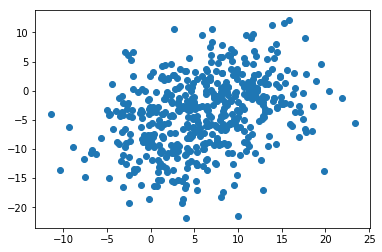

In [2]:
# Random seed
np.random.seed(1)

# Create a dataset of Gaussian blobs
X, _ = make_blobs(n_samples=500, centers=2, cluster_std=5.0, random_state=1000)

# Plot the data
plt.scatter(X[:,0], X[:,1])
plt.show()

## Rescale

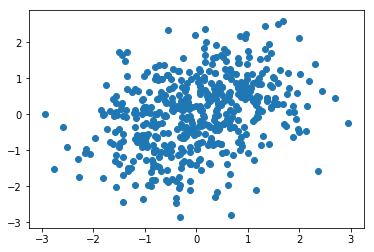

In [3]:
# Rescale to have zero mean and standard devation 1
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Plot the data
plt.scatter(Xs[:,0], Xs[:,1])
plt.show()

## Evolve neuron according to Oja's Rule

In [23]:
# Generate initial weights
W = np.random.normal(scale=0.25, size=(2,1))
W_prev = np.ones((2,1))

# learning rate and tolerance of change in weights
eps = 1e-5
tol = 1e-9

# this implementation is one-to-one from the Bonaccorso (2017)
# it is very straightforward
while np.linalg.norm(W - W_prev) > tol:
    W_prev = W.copy()
    Y = np.dot(Xs, W)
    W += eps * np.sum(Y*Xs - np.square(Y)*W.T, axis=0).reshape((2,1))

## Now compare results with eigenvector of covariance matrix (1st principal component)

In [30]:
C = np.cov(Xs.T)
eigval, eigvec = np.linalg.eig(C)

print(eigvec[0])
print(np.reshape(W, 2))

[-0.70710678 -0.70710678]
[ 0.70710699  0.70710657]


## Plot this vector through the data

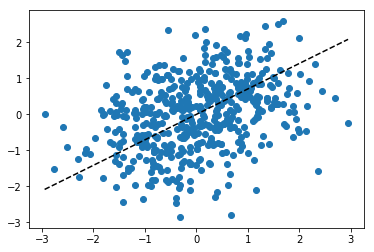

In [32]:
# Plot the data
plt.scatter(Xs[:,0], Xs[:,1])

# Plot the weight vector
xx = np.linspace(np.min(Xs), np.max(Xs), num=500)
plt.plot(xx, W[1]*xx, '--k')
plt.show()

## References

Bonaccorso, Giuseppe (2017, Aug 21). ML algorithms addendum: hebbian learning. Retrieved at: https://www.bonaccorso.eu/2017/08/21/ml-algorithms-addendum-hebbian-learning/

Oja, Erkki (2008). Oja learning rule, $\textit{Scholarpedia}$, 3(3):3612. Retrieved at: http://www.scholarpedia.org/article/Oja_learning_rule.